(lecture07:estimating-probabilities-simulation)=
# Estimating probabilities by simulation

I will teach you now a very powerful method for estimating probabilities that is
typically reserved for much later in probability courses.
It is true that proving why it works requires advanced mathematics.
But developing intuition about the method is trival.
Also implementing it just requires that you understand loops and conditionals.
So let's not wait!
Let's learn about Monte Carlo simulations!

Say that you want to calculate the probability $p(A|I)$ of a logical proposition $A$
given some background information $I$.
The idea is to write computer code that simulates the experiment of measuring
$A$ under $I$, run it many times, and calculate the frequency with which $A$
is True under $I$.
So, you set:

$$
p(A|I) \approx \frac{\text{Number of times}\;A\;\text{is True under}\;I\;\text{in}\;N\;\text{simulated experiments}}{N}.
$$

Now the larger the number of simulated experiments $N$, the closer your estimate
would be.
In a math course, you actually show that this method is a consequence of a
theorem called the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).

Let's see this working in practice.
Let's load the usual libraries for plotting.

In [17]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(lecture07:simulating-a-coin-toss-experiment)=
## Simulating a coin toss experiment

We are going to simulate a coin toss experiment.
We basically need the ability to randomly pick between the numbers $0$ and $1$.
This is sufficient because we can associate $0$ with tails and $1$ with heads.
Python has a function that can generate random integers for you.
It is called [numpy.random.randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html).
Let's see how it works before we setup our coin toss experiment.

The simplest way to call `randint()` is `randint(low, high)` where `low` and `high` are two integers.
Then it will respond with a random integer between `low` and `high - 1`.
So, if we want to pick randomly between $0$ and $1$, we have to call it like this:

In [18]:
import numpy as np
np.random.randint(0, 2)

0

Now, if you want to call it multiple times, you can either make a loop:

In [19]:
for i in range(10):
    print(np.random.randint(0, 2))

1
1
0
0
0
0
1
1
0
0


Or you can call it by specifying the keyword argument `size`:

In [20]:
np.random.randint(0, 2, size=10)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0])

Now, you may wonder: "Computers are deterministic machines. How can they generate random numbers?"
Well, they can't...
These are not true random numbers.
They are pseudo-random numbers!
But they look like random numbers so they are good enough for simulating experiments.
If you want to learn more about how pseudo-random number generators work see [this](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/activities/hands-on-07.1.ipynb).
What you need to know is that there is a thing called `seed` that uniquely specifies the sequence of random numbers you get.
The seed can be any integer.
Look at this:

In [21]:
np.random.seed(12345)
np.random.randint(0, 2, size=20)

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])

Now, if I run the code again I get another sequence of random results:

In [22]:
np.random.randint(0, 2, size=20)

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

But if I fix the seed again (to the same integer 12345), I get exactly the same results:

In [23]:
np.random.seed(12345)
np.random.randint(0, 2, size=20)

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])

```{important}
When writing code that simulates random experiments it is always a good idea to fix the random seed at the very beginning.
This ensures that other people who run your code will get exactly the same results as you do!
```

Okay, let's go back to the coin toss experiment.
How do we simulate it.
Well, we are done.
You just `np.random.randint(0, 2, size=N)` for any $N$ you like and you simulate it.
Let's now use this to estimate the probability of heads.
To get the estimate we have to divide the number of heads with $N$.
Since we are associating heads with the experimental result $1$, then we can find the number of heads by summing up the result of all the experimental runs.
So, we are doing this:

$$
p(H|I) \approx \frac{\text{result}\;1+\;\dots\;\text{result}\;N}{N}.
$$

This is easy. Here we go:

In [24]:
# Set the seed for reproducibility
np.random.seed(12345)
# Pick the number of coin toss experiments you want to simulate
N = 5
# Simulate the experiments
coin_toss_exp = np.random.randint(0, 2, size=N)
# Approximate the probability
p_H_g_I = coin_toss_exp.sum() / N
# Print the estimate
print(f'p(H|I) ~= {p_H_g_I:1.5f}')

p(H|I) ~= 0.60000


This seems quite off from what we expected ($0.5$).
But, hey, we just used $N=5$ experiment.
We need to use much more than this.
Let's repeat with $N=1000$:

In [25]:
N = 1000
coin_toss_exp = np.random.randint(0, 2, size=N)
p_H_g_I = coin_toss_exp.sum() / N
print(f'p(H|I) ~= {p_H_g_I:1.5f}')

p(H|I) ~= 0.50800


Okay, this is almost perfect.
Now, how do you know how many experiments you should simulate?
There is a theoretical answer to that as well, but we are not equipped yet to understand it.
But what you can do, is you can plot your estimate of the probability $p(H|I)$ as a function of the number of simulated experiments $N$.
If we do that, we will have a visual indication that our estimate is converging.
Let's do this.

In [26]:
# Let's pick a really big number for N
N = 10_000 # Yes, no typo here. You can do this with numbers in Python!
coin_toss_exp = np.random.randint(0, 2, size=N)

We have the experiment done ten thousand times.
Now let's produce our estimate of the probability using $n$ experiments for $n=1$ to $N$.
We can do it with a for loop:

In [27]:
# Make an empty array to store the results
p_H_g_I_estimates = np.ndarray((N,))
# Loop over the number of experiments
for n in range(N):
    p_H_g_I_estimates[n] = coin_toss_exp[:n].sum() / (n + 1)

````{note}
This works well, but you can also do it without the for loop using the [numpy.cumsum()](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) function:

```python
p_H_g_I_estimates = np.cumsum(coin_toss_exp) / np.arange(1, N + 1)
```

````

Now, let's plot the probability estiamte as a function of the number of simulated experiments:

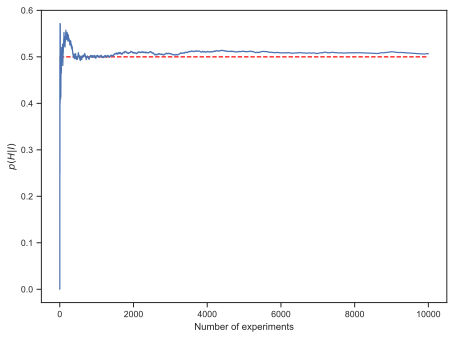

In [28]:
fig, ax = make_full_width_fig()
ax.plot(np.arange(1, N + 1), [0.5] * np.ones((N,)), 'r--', label='True value')
ax.plot(np.arange(1, N + 1), p_H_g_I_estimates, label='Monte Carlo estimate')
ax.set_xlabel('Number of experiments')
ax.set_ylabel('$p(H|I)$')
save_for_book(fig, 'ch7.fig1')

So, it comes pretty close to the true value after about $4000$ experiments.